In [3]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from BayesianExperimentalDesign import BED
from compute_distance import kl_divergence_gaussian_known_q, wasserstein_distance_deterministic
from multiprocessing import freeze_support
from IPython.display import display, clear_output
%matplotlib inline
np.random.seed(41)

In [4]:
# Monte Carlo sampling parameters
N = 12000 # Outer samples
M = 12000 # Inner samples
num_iter = 11

num_dusts = 2
num_airports = 15
num_engines = 8

x_real = np.random.multivariate_normal(np.array([4.5,5.5]), np.array([[0.8,0.02],[0.02,0.8]]), size=num_airports)
x_real = np.abs(x_real)

sigma_real = 0.001
x_real_flat = x_real.reshape(num_dusts*num_airports)
# Variance
sigma = 0.25

Acon = np.zeros(num_airports)
Acon[0] = 1
# Frequency matrix N_E * N_A
for i in range(num_engines):
    B = np.zeros(num_airports)
    for j in range((i+1)//1+1):
        B[j] = 1/((i+1)//1+1)
    Acon = np.vstack((Acon, B))

Acon = np.load('engine_airport_frequency.npy')

Acon = np.array([np.random.permutation(row) for row in Acon])

Acon = Acon / Acon.sum(axis=1, keepdims=True)

mean = (Acon @ x_real)
measure_noise = np.full_like(mean, 0)
for i in range(500):
    measure_noise  += np.random.normal(loc=np.full_like(mean, 0), scale=sigma_real)
measureall = mean + measure_noise



BEDmodel_optimal = BED(Acon, num_dusts, sigma)
BEDmodel_random = BED(Acon, num_dusts, sigma)


num_chosen = 1
np.random.seed(2)
prior_sigma = 4
prior_mu = 5
prior_samples =  np.random.normal(prior_mu, prior_sigma, size=(3000, num_dusts*num_airports))

wd = np.zeros(30)
kld = np.zeros(30)
lwd = np.zeros(30)
lkld = np.zeros(30)

In [5]:
measureall

array([[4.77509167, 5.28100689],
       [4.78640229, 4.72126223],
       [4.92050896, 5.27160002],
       [4.77088021, 5.28294274],
       [4.58441264, 5.238074  ],
       [4.88762739, 5.1998625 ],
       [4.71503697, 5.47115032],
       [4.83126741, 5.30855422]])

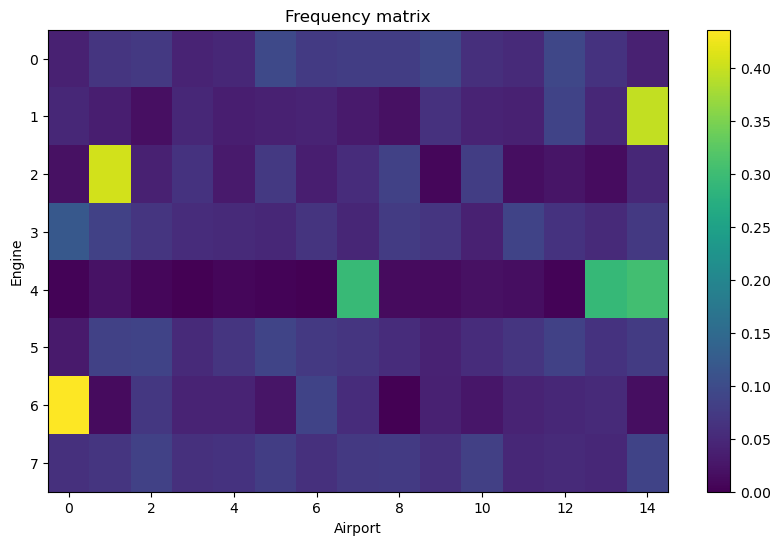

In [6]:
plt.figure(figsize=(10, 6))
plt.imshow(Acon, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Frequency matrix")
plt.xlabel("Airport")
plt.ylabel("Engine")
plt.savefig('frequency_matrix.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#20 mixture
k_cumu = 0
for k in [1]:
    num_chosen = k 
    BEDmodel_optimal.A = Acon
    BEDmodel_optimal.num_engines = BEDmodel_optimal.A.shape[0]

    
    opt_design, eigs = BEDmodel_optimal.initial_design(num_chosen, N, M)
    opt_designs = opt_design
    print(eigs)
    #to be deleted
    #opt_design = np.array([6])#np.random.choice(np.arange(0, num_engines), size=num_chosen, replace=False)
    measure = np.array(measureall[opt_designs,:]).flatten()
    posteriordata = BEDmodel_optimal.do_experiment(opt_design, measure, N)
    posteriordatav = posteriordata.posterior["x"].values
    posteriordatav = posteriordatav.reshape(posteriordatav.shape[0] * posteriordatav.shape[1], num_dusts*num_airports)


    A_optimal = BEDmodel_optimal.A[opt_design,:]
    BEDmodel_optimal.A = np.delete(BEDmodel_optimal.A, opt_design, axis=0)
    BEDmodel_optimal.num_engines = BEDmodel_optimal.A.shape[0]
    

    for i in range(1, 3):
        xn_samples, xm_samples = BEDmodel_optimal.reuse_posterior_samples(posteriordata, 5000, 5000)
        opt_design, eigs = BEDmodel_optimal.sequential_design(num_chosen, xn_samples, xm_samples)   
        opt_designs = [opt_designs, opt_design]
        print(eigs)
        A_optimal = np.vstack([A_optimal, BEDmodel_optimal.A[opt_design,:]])
        measure = np.array(measureall[opt_designs,:]).flatten()
        posteriordata = BEDmodel_optimal.do_experiment(opt_design, measure, N, A_optimal) 
        posteriordatav = posteriordata.posterior["x"].values
        posteriordatav = posteriordatav.reshape(posteriordatav.shape[0] * posteriordatav.shape[1],
                                                num_dusts*num_airports)

        BEDmodel_optimal.A = np.delete(BEDmodel_optimal.A, opt_design, axis=0)
        BEDmodel_optimal.num_engines = BEDmodel_optimal.A.shape[0]

    k_cumu = int(num_engines/k) + k_cumu
    
plt.ioff()
plt.show()


Computing EIG for each design: 100%|██████████| 8/8 [01:15<00:00,  9.48s/it]


Optimal engine subset for measurement: (4,)
[array([[1.7363153]]), array([[2.58552666]]), array([[2.64718797]]), array([[1.72711112]]), array([[2.89693952]]), array([[1.72900969]]), array([[2.69383594]]), array([[1.6975825]])]


Output()

Computing EIG for each design: 100%|██████████| 7/7 [02:04<00:00, 17.78s/it]


Optimal engine subset for measurement: (5,)
[array([[1.54271317]]), array([[2.07928126]]), array([[2.56142458]]), array([[1.5866079]]), array([[1.49026685]]), array([[2.68473517]]), array([[1.47474505]])]


Output()

Computing EIG for each design: 100%|██████████| 6/6 [01:48<00:00, 18.14s/it]


Optimal engine subset for measurement: (2,)
[array([[1.40685177]]), array([[2.03024541]]), array([[2.5666333]]), array([[1.14947235]]), array([[1.36364058]]), array([[1.2741774]])]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.